# Notebook Walkthrough for Evaluating Effects of Image Perurbation on PCA Logistic Regression

### All Project Notebooks

This walkthrough only covers the implementation and evaluation of PCA logistic regression on a perturbed test set. There were several other notebooks that our group wrote to produce all of the results of our project. A list of these notebooks and links to them are provided here. Instructions for how to download the data and run the code can be found in [the README](https://github.com/ben-heil/texture_learning/blob/master/README.md)

#### Competing Models

1. [Training and Evaluating ResNet](https://github.com/ben-heil/texture_learning/blob/master/code/resnet_train.ipynb)
2. [Training and Evaluating BagNet](https://github.com/ben-heil/texture_learning/blob/master/code/bagnet_train.ipynb)
3. [Training and Evaluating VGG](https://github.com/ben-heil/texture_learning/blob/master/code/vgg_train.ipynb)
4. [Training and Evaluating simplenet](https://github.com/ben-heil/texture_learning/blob/master/code/five_layer_CNN_train.ipynb)

#### Other Notebooks

1. [Fitting the dummy classifier](https://github.com/ben-heil/texture_learning/blob/master/code/dummyclassifier.ipynb)
2. [Generating the texturized images](https://github.com/ben-heil/texture_learning/blob/master/code/texturize_images.ipynb)

## Data Exploration

Here, we will set up our data generators (training, and the test generator that perturbs images). We'll visualize a few plants and examine how perturbation affects the images.

First, let's import the requisite packages

In [10]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils import data
import torch
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from skimage.io import imread
from numpy.random import poisson, normal, beta, choice
import time
from copy import deepcopy, copy
from PIL import Image

The dataset contains images of plant seedlings. The dataset was obtained from a Kaggle competition where the goal was to predict the plant time from an image of its seedling. Our dataset contains 4750 images for training, and 794 images for testing. The labels for the test set are not availible. To evaluate performance on the test set, a csv file containing predictions must be submitted to Kaggle, and an F1 score will be returned.

Let's set the seed for reproducibility, and then prepare our dataset loader. For preprocessing, we will first resize images to $255 \times 255$ (length times width). Then, we crop the image with CenterCrop, and convert the image to a tensor.

We create a "dataset" object with which we can import images from a directory on demand. Finally, we split up the training data into an actual training set (90% of availible training data) and a tuning set (10% of availible training data).

In [11]:
seed = 42

np.random.seed(seed)                                                                       
torch.manual_seed(seed) 

img_transform = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])]
                                   )

#change train_path to wherever the training data is stored.
train_path = '../data/train'

dataset = ImageFolder(root=train_path, transform=img_transform)

train_indices, tune_indices = sklearn.model_selection.train_test_split(np.arange(len(dataset)), 
                                                                       test_size=.1, random_state=seed)
print(dataset.classes)
print("\n The number of images availible for training is: " + str(len(dataset)))

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']

 The number of images availible for training is: 4750


Below are some helper function that can be used to perturb the images at test time.

In [12]:
"""
 This is a function that takes in an image, and a dispersion parameter
 p and n define the size of the mean pixel patch and the number of patches
 replaces pixel with random noise in randomly selected patches of the image
"""

def patchnoiser(image, theta, p , n):
    x, y, c = image.shape
    means = torch.sum(image, dim=(0,1))/x/y
    
    for i in range(n):
        px = min(poisson(lam = p, size=None), x)
        py = min(poisson(lam = p, size=None), y)
        
        max_x = x + 1 - px
        max_y = y + 1 - py
        
        x_range = list(range(max_x))
        y_range = list(range(max_y))
        
        patch1_x = choice(x_range)
        patch1_y = choice(y_range)
        
        def pixeltonoise(x):
            if(x < 10 **(-6)):
                return x
            if(x > 1 - 10**(-6)):
                return x

            a = (1 - theta) / theta * x
            b = (1 - theta) / theta * (1 - x)

            return(beta(a, b))
    
        pixeltonoise = np.vectorize(pixeltonoise)
        
        noise0 = pixeltonoise(float(means[0]) * np.ones(shape = (px, py)) )
        noise1 = pixeltonoise(float(means[1]) * np.ones(shape = (px, py)) )
        noise2 = pixeltonoise(float(means[2]) * np.ones(shape = (px, py)) )
        
        noise0 = torch.from_numpy(noise0)
        noise1 = torch.from_numpy(noise1)
        noise2 = torch.from_numpy(noise2)
        
        image[patch1_x:(patch1_x+px), patch1_y:(patch1_y + py), 0] = noise0
        image[patch1_x:(patch1_x+px), patch1_y:(patch1_y + py), 1] = noise1
        image[patch1_x:(patch1_x+px), patch1_y:(patch1_y + py), 2] = noise2
    
    return(image)

"""
 This is a function that takes in an image, and a dispersion parameter
 replaces each pixel with a noisy version of that pixel 
"""

def uniformnoiser(image, theta):
    x, y, c = image.shape
    
    def pixeltonoise(x):
        if(x < 10 **(-6)):
            return x
        if(x > 1 - 10**(-6)):
            return x
        
        a = (1 - theta) / theta * x
        b = (1 - theta) / theta * (1 - x)
        
        return(beta(a, b))
    
    pixeltonoise = np.vectorize(pixeltonoise)
    
    image = np.asarray(image)
    image = pixeltonoise(image)
    image = torch.from_numpy(image)
    
    return(image)

"""
 This is a function that takes in an image, and a dispersion parameter
 p and n define the size of the mean pixel patch and the number of patches
 replaces pixel with random noise in randomly selected patches of the image
"""

def patchswap(image, p, n):
    x, y, c = image.shape
    
    for i in range(n):
        px = min(poisson(lam=p, size=None), x)
        py = min(poisson(lam=p, size=None), y)
        
        max_x = x + 1 - px
        max_y = y + 1 - py
        
        x_range = list(range(max_x))
        y_range = list(range(max_y))
        
        patch1_x = choice(x_range)
        patch1_y = choice(y_range)
        patch1 = deepcopy(image[patch1_x:(patch1_x + px), patch1_y:(patch1_y + py), 0:3])

        patch2_x = choice(x_range)
        patch2_y = choice(y_range)
        patch2 = deepcopy(image[patch2_x:(patch2_x + px), patch2_y:(patch2_y + py), 0:3])
        
        image[patch1_x:(patch1_x + px), patch1_y:(patch1_y + py), 0:3] = patch2
        image[patch2_x:(patch2_x + px), patch2_y:(patch2_y + py), 0:3] = patch1
    
    return(image)

The following code chunk defines the tgenerator class that generates the images at test time. In it's getitem method, the class will apply an image perturbation method on the loaded image. By default, no perturbation is applied.

Note that texturization is not included in this class since texturized images take so long to produce. The texturized images are produced by a separate notebook. To generate the texturized images, run that notebook and save the texturized images in a different directory, then call the generator on that directory with no perturbation.

In [13]:
"""A pytorch dataset class that retrieves and modifies images in real time
    Corruption Modes:
        1. None: return clean resized image
        2. patchswap: swap patches of pixels
        3. noisypatch: Randomly select patches of pixels and replace them with randomly distributed noise
        4. uniformnoise: For each pixel, replace that pixel's color values with noisy versions of that 
            pixel's color values
"""
class tgenerator(data.Dataset):

    def __init__(self, IDlink):
        'Initialization'
        self.link = IDlink
        self.list_IDs = listdir(IDlink)
        self.mode = 'None'
        self.imageview = True
        self.transformer = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])])
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def viewmode(self):
        '''Switch the shaping of the tensors. For CNN models, call this method in order
        to ensure that the first dimension of the image tensor is the channel'''
        self.imageview = not self.imageview
    
    def setmode_none(self):
        self.mode = 'none'
    
    def setmode_patchswap(self,p = 1, n = 0):
        self.mode = 'patchswap'
        self.p = p
        self.n = n
        
    def setmode_noisypatch(self, theta = 1/4, p = 1, n = 0):
        self.mode = 'noisypatch'
        self.theta = theta
        self.p = p
        self.n = n
        
    def setmode_uniformnoise(self, theta = 1/4):
        self.mode = 'uniformnoise'
        self.theta = theta
        
    def setparams(self, resize=255, centercrop=224):
        self.size = size
        self.transformer = transforms.Compose([transforms.Resize(resize),
                                    transforms.CenterCrop(centercrop),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])]
        )
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = Image.open(self.link + '/' + ID)
        X = self.transformer(X)
        X = X.permute(1,2,0)
        
        if(self.mode == 'patchswap'):
            X = patchswap(X, self.p, self.n)
            
        if(self.mode == 'noisypatch'):
            X = patchnoiser(X, self.theta, self.p, self.n)
            
        if(self.mode == 'uniformnoise'):
            X = uniformnoiser(X, self.theta)

        if(not self.imageview):
            X = X.permute(2,0,1)
            
        return X

First, let's visualize an image using the tgenerator class with no image perturbation.

The number of test images is 794


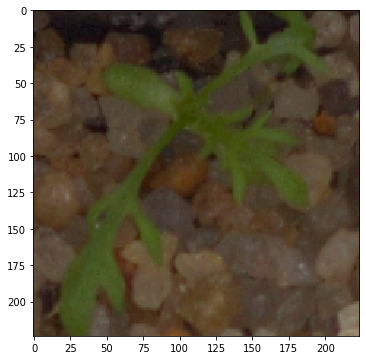

In [14]:
test_dir = "../data/test"
testset = tgenerator(test_dir)
print("The number of test images is " + str(len(testset)))

"""Get a clean image"""

i = choice(list(range(len(testset))))
testset.setmode_none()
image = testset[i]

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.show()

Next, let's visualize the same image using the tgenerator with patch swap perturbation. Here, each image is perturbed via average patch dimension p=20 and 50 swaps.

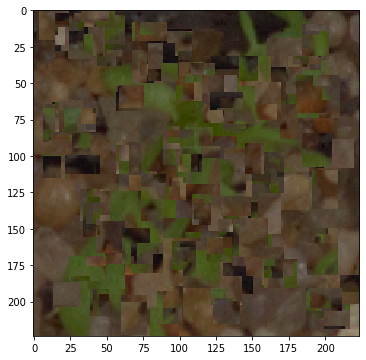

In [15]:
testset.setmode_patchswap(p=20, n=50)
image = testset[i]

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.show()

Next, let's visualize the same image using the tgenerator with noisy patch perturbation. The parameters used are theta=0.1, p=30, n=40.

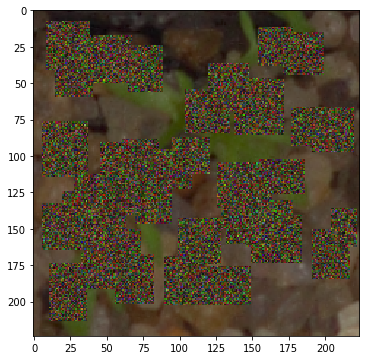

In [16]:
testset.setmode_noisypatch(theta=0.1, p=30, n=40)
image = testset[i]

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.show()

Lastly, let's visualize the image using the tgenerator with uniform noise perturbation. The parameter used is theta=0.6.

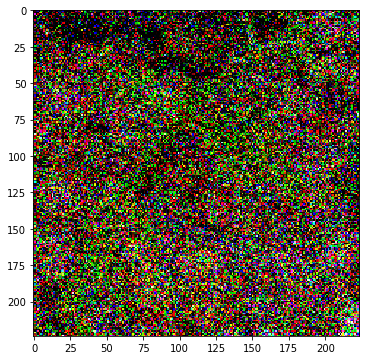

In [17]:
testset.setmode_uniformnoise(theta=0.6)
image = testset[i]

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.show()

Below, we define the getnewmatrix function which will use the python dataset object to load images one at a time and reshape them into a typical sample by feature matrix that is conventional to PCA and logistic regression analyses. Then, this matrix is partitioned into a training and tuning matrix.

In [9]:
def getnewmatrix(ds):
    y = []
    imgdat = np.zeros((len(ds), 224 * 224 * 3),dtype=float)
    q = 0

    for i in range(len(ds)):
        y = y + [ds[i][1]]

        im = ds[i][0]
        
        imnew = im.view(-1, im.shape[0] * im.shape[1] * im.shape[2])
        imnew = np.asarray(imnew)
        imgdat[i,] = imnew
        
        if (i % 500 == 0):
            print(i)

    return imgdat, np.asarray(y)

X, y = getnewmatrix(dataset)

Xtrain, ytrain = X[train_indices,], y[train_indices]
Xtune, ytune = X[tune_indices,], y[tune_indices]

0
500
1000
1500
2000
2500
3000
3500
4000
4500


## Model Walkthrough

Here we walk through the process of determining the optimal number of PCs for PCA, fitting the PCA and then the logistic regression on the dimension reduced data, and then evaluating this fitted PCA regression method on the test set after application of a variety of image perturbation methods.

Since training is fast and the logistic regression is fit all at once with the sklearn LogisticRegression function, no training or test curve is provided for this specific method. However in our other notebooks where we fit the various CNN models (resnet, bagnet, vgg, simplenet) training and test curves are provided

A hyperparameter that we need to select is the number of principal components to retain when projecting the data into a low-dimensional space before fitting the logistic regression. We will do this by comparing validation accuracy of the model for various numbers of retained principal components. For each possible value k of the hyperparameter proceed as follows: 

First perform PCA dimension reduction on Xtrain to get Ztrain, where Ztrain is obtained by multiplying Xtrain by a matrix Vk whose columns contain only the k most important eigenvectors of the covariance matrix of Xtrain. Then, fit the logistic regression on Ztrain. Then, project validation data Xtune into the dimension reduced space by computing Xtune * Vk = Ztune. Then predict on Ztune using the fitted logistic regression and save the validation accuracy. The value of k which yields the highest validation accuracy is saved as the number of PCs for downstream analysis.

In [10]:
PCs = [5, 10, 20, 40, 80, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 1000]
accs = [0] * len (PCs)

for i in range(len(PCs)):
    myPCA = PCA(n_components = PCs[i])
    myPCA.fit(Xtrain)
    Ztrain = myPCA.transform(Xtrain)
    clf = LogisticRegression(random_state=0, solver='saga', max_iter = 10000).fit(Ztrain, ytrain)
    
    Ztune = myPCA.transform(Xtune)
    accs[i] = clf.score(Ztune, ytune)
    print(PCs[i])
    print(accs[i])

accs = np.asarray(accs)
ncomp = PCs[np.argmax(accs)]

/Users/jlakkis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


5
0.17684210526315788


/Users/jlakkis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


10
0.18736842105263157


/Users/jlakkis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


20
0.2736842105263158


/Users/jlakkis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


40
0.38105263157894737


/Users/jlakkis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


80
0.47368421052631576


/Users/jlakkis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


100
0.47578947368421054


/Users/jlakkis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


150
0.4884210526315789


/Users/jlakkis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


200
0.4884210526315789


/Users/jlakkis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


250
0.5073684210526316


/Users/jlakkis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


300
0.5073684210526316


/Users/jlakkis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


400
0.47157894736842104


/Users/jlakkis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


500
0.4610526315789474


/Users/jlakkis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


600
0.47157894736842104


/Users/jlakkis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


700
0.4968421052631579


/Users/jlakkis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


800
0.45052631578947366


/Users/jlakkis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


1000
0.44


Fit the PCA on all of the training data (both the actual training and the validation data) using the number of PCs k obtained from the hyperparameter tuning. Then retain only the k most important eigenvectors in the loadings matrix, and compute Z = X * Vk

In [11]:
myPCA = PCA(n_components = ncomp)
myPCA.fit(X)
Z = myPCA.transform(X)
Z.shape

(4750, 250)

Fit the logistic regression on Z

In [12]:
clf = LogisticRegression(random_state=0, solver='saga', max_iter = 10000).fit(Z, y)

/Users/jlakkis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Initialize a dataframe which will contain the predictions on the test set. This dataframe is formatted such that the saved csv file can be submitted to Kaggle to get an F1 score.

In [13]:
index = list(range(794))
columns=['file','species']
df_ = pd.DataFrame(index = index, columns=columns)
df_ = df_.fillna(0)

Initialize the generator class. Calling the viewmode method ensures that the image tensors are shaped with channels as the first dimension.

In [14]:
test_dir = "../data/test"
testset = tgenerator(test_dir)
testset.viewmode()

Let's get predictions on the unperturbed test set.

Load each image one at a time. Reshape it as a vector, project the vector into the PCA dimension-reduced space, and make a prediction on the dimension-reduced vector with logistic regression. Save the prediction to the dataframe. When predictions have been made for all of the images, export the dataframe as a csv file.

To reproduce our F1 score, submit the csv file as a late submission for the Kaggle plant seedlings classification challenge here: https://www.kaggle.com/c/plant-seedlings-classification/submit

Our F1 score was: 0.52581

In [15]:
for i in range(794):
    im = testset[i]
    imnew = im.view(-1,im.shape[0] * im.shape[1] * im.shape[2])
    imnew = np.asarray(imnew)
    z = myPCA.transform(imnew)
    ytest = clf.predict(z)
    
    if(i % 100 ==0):
        print(i)
    
    df_['file'][i] = testset.list_IDs[i]
    df_['species'][i] = dataset.classes[int(ytest)]
    
df_.to_csv(path_or_buf = "../results/lr_predictions.csv", index = False)

0


/Users/jlakkis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/jlakkis/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


100
200
300
400
500
600
700


Let's get predictions on the uniformnoise perturbed test set.

Load each image one at a time. Reshape it as a vector, project the vector into the PCA dimension-reduced space, and make a prediction on the dimension-reduced vector with logistic regression. Save the prediction to the dataframe. When predictions have been made for all of the images, export the dataframe as a csv file.

To reproduce our F1 score, submit the csv file as a late submission for the Kaggle plant seedlings classification challenge here: https://www.kaggle.com/c/plant-seedlings-classification/submit

Our F1 score was: 0.51070

In [16]:
testset.setmode_uniformnoise(theta=0.6)

for i in range(794):
    im = testset[i]
    imnew = im.view(-1, im.shape[0] * im.shape[1] * im.shape[2])
    imnew = np.asarray(imnew)
    z = myPCA.transform(imnew)
    ytest = clf.predict(z)
    
    if(i % 100 ==0):
        print(i)
    
    df_['file'][i] = testset.list_IDs[i]
    df_['species'][i] = dataset.classes[int(ytest)]
    
df_.to_csv(path_or_buf = "../results/lr_predictionsunoise.csv", index = False)

0
100
200
300
400
500
600
700


Let's get predictions on the noisypatch perturbed test set.

Load each image one at a time. Reshape it as a vector, project the vector into the PCA dimension-reduced space, and make a prediction on the dimension-reduced vector with logistic regression. Save the prediction to the dataframe. When predictions have been made for all of the images, export the dataframe as a csv file.

To reproduce our F1 score, submit the csv file as a late submission for the Kaggle plant seedlings classification challenge here: https://www.kaggle.com/c/plant-seedlings-classification/submit

Our F1 score was: 0.40113

In [17]:
testset.setmode_noisypatch(theta=0.1,p=30,n=40)

for i in range(794):
    im = testset[i]
    imnew = im.view(-1, im.shape[0] * im.shape[1] * im.shape[2])
    imnew = np.asarray(imnew)
    z = myPCA.transform(imnew)
    ytest = clf.predict(z)
    
    if(i % 100 ==0):
        print(i)
    
    df_['file'][i] = testset.list_IDs[i]
    df_['species'][i] = dataset.classes[int(ytest)]
    
df_.to_csv(path_or_buf = "../results/lr_predictionsnoisypatch.csv", index = False)

0
100
200
300
400
500
600
700


Let's get predictions on the patchswap perturbed test set.

Load each image one at a time. Reshape it as a vector, project the vector into the PCA dimension-reduced space, and make a prediction on the dimension-reduced vector with logistic regression. Save the prediction to the dataframe. When predictions have been made for all of the images, export the dataframe as a csv file.

To reproduce our F1 score, submit the csv file as a late submission for the Kaggle plant seedlings classification challenge here: https://www.kaggle.com/c/plant-seedlings-classification/submit

Our F1 score was: 0.39546

In [18]:
testset.setmode_patchswap(p=20, n=50)

for i in range(794):
    im = testset[i]
    imnew = im.view(-1, im.shape[0] * im.shape[1] * im.shape[2])
    imnew = np.asarray(imnew)
    z = myPCA.transform(imnew)
    ytest = clf.predict(z)
    
    if(i % 100 ==0):
        print(i)
    
    df_['file'][i] = testset.list_IDs[i]
    df_['species'][i] = dataset.classes[int(ytest)]
    
df_.to_csv(path_or_buf = "../results/predictionspatchswap.csv", index = False)

0
100
200
300
400
500
600
700


Let's get predictions on the texturized perturbed test set. For the texturized images, we have to reinitialize the generator object and change the directory. This is because the texturized images take a long time to produce, so they had to produced and saved in a directory before this walkthrough. No perturbation is enabled in the generator since the directory contains images that are already perturbed.

Load each image one at a time. Reshape it as a vector, project the vector into the PCA dimension-reduced space, and make a prediction on the dimension-reduced vector with logistic regression. Save the prediction to the dataframe. When predictions have been made for all of the images, export the dataframe as a csv file.

To reproduce our F1 score, submit the csv file as a late submission for the Kaggle plant seedlings classification challenge here: https://www.kaggle.com/c/plant-seedlings-classification/submit

Our F1 score was: 0.28589

In [19]:
texture_data_dir = "../data/texturized"
testset = tgenerator(texture_data_dir)
testset.viewmode()

for i in range(794):
    im = testset[i]
    imnew = im.view(-1, im.shape[0] * im.shape[1] * im.shape[2])
    imnew = np.asarray(imnew)
    z = myPCA.transform(imnew)
    ytest = clf.predict(z)
    
    if(i % 100 ==0):
        print(i)
    
    df_['file'][i] = testset.list_IDs[i]
    df_['species'][i] = dataset.classes[int(ytest)]
    
df_.to_csv(path_or_buf = "../results/lr_predictionstexturized.csv", index = False)

0
100
200
300
400
500
600
700
